In [1]:
from data_utils import *
from kitti_utils import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# from publish_utils import *
import math
import random
import copy

CONSTANTS_RADIUS_OF_EARTH = 6371000.     # meters (m)
FPS = 10

############   定位部分             ###########
#通过GPS经纬度的到平面坐标
def GPStoXY(lat, lon, ref_lat, ref_lon):
        # input GPS and Reference GPS in degrees
        # output XY in meters (m) X:North Y:East
        lat_rad = math.radians(lat)
        lon_rad = math.radians(lon)
        ref_lat_rad = math.radians(ref_lat)
        ref_lon_rad = math.radians(ref_lon)

        sin_lat = math.sin(lat_rad)
        cos_lat = math.cos(lat_rad)
        ref_sin_lat = math.sin(ref_lat_rad)
        ref_cos_lat = math.cos(ref_lat_rad)

        cos_d_lon = math.cos(lon_rad - ref_lon_rad)

        arg = np.clip(ref_sin_lat * sin_lat + ref_cos_lat * cos_lat * cos_d_lon, -1.0, 1.0)
        c = math.acos(arg)

        k = 1.0
        if abs(c) > 0:
            k = (c / math.sin(c))

        x = float(k * (ref_cos_lat * sin_lat - ref_sin_lat * cos_lat * cos_d_lon) * CONSTANTS_RADIUS_OF_EARTH)
        y = float(k * cos_lat * math.sin(lon_rad - ref_lon_rad) * CONSTANTS_RADIUS_OF_EARTH)

        return x, y
#定义使用GPS计算单位时间移动距离方法（速度）
def computer_great_circle_distance(lat1,lon1,lat2,lon2):
    delta_sigma = float(np.sin(lat1*np.pi/180)*np.sin(lat2*np.pi/180)+\
                        np.cos(lat1*np.pi/180)*np.cos(lat2*np.pi/180)*np.cos(lon1*np.pi/180-lon2*np.pi/180))
    return 6371000.0*np.arccos(np.clip(delta_sigma,-1,1))


#传入3x4变换矩阵的一串str输出[x,y,z],yaw
def parse_pose_matrix(pose_str):
    pose_matrix = np.array(pose_str.split(" "))
    pose_matrix.resize(3,4)
    pose_matrix = pose_matrix.astype(float)
    # 将变换矩阵解析为平移向量和旋转矩阵
    translation = pose_matrix[:3, 3]
    rotation_matrix = pose_matrix[:3, :3]
    # 从旋转矩阵中解析航向角
    pitch = np.arcsin(rotation_matrix[0, 2])
    roll = np.arctan2(-rotation_matrix[0, 1], rotation_matrix[0, 0])
    yaw = np.arctan2(-rotation_matrix[1, 2], rotation_matrix[2, 2])
    return translation, yaw


#3d
def get_odom_from_imu(raw_data):
    global FPS
    prev_imu_data = None
    locations = []

    for imu_data in raw_data:
        
        if prev_imu_data is not None:
            displacement = (1/FPS)*np.linalg.norm(imu_data[['vf','vl']])
            x0, y0 ,z0,w0= locations[-1]
            x1  = x0 - (displacement * np.sin(imu_data.yaw - prev_imu_data.yaw))
            y1  = y0 + (displacement * np.cos(imu_data.yaw- prev_imu_data.yaw))
            
#             a = 6378137.0  # Earth's radius (in meters)
#             b = 6356752.3142
#             e = np.sqrt(1 - (b/a)**2)
#             N = a / np.sqrt(1 - e**2 * np.sin(np.radians(imu_data.alt))**2)
#             z1  = ((1 - e**2) * N + imu_data.alt) * np.sin(np.radians(imu_data.alt))
            z1 = imu_data.alt - z1_first
            locations += [np.array([float(x1),float(y1),float(z1),float(imu_data.yaw- prev_imu_data.yaw)])]
        else:
            locations += [np.array([0,0,0,0])]    
            prev_imu_data =   imu_data
            z1_first = imu_data.alt
                 
    return locations


#3d
def get_odom_from_gps(raw_data):
    first_imu_data = None
    locations = []


    for imu_data in raw_data:
        if first_imu_data is not None:
            x,y = GPStoXY(imu_data.lat,imu_data. lon, first_imu_data.lat, first_imu_data.lon)

            theta_ = first_imu_data.yaw
            x  =(x - y*np.tan(theta_))*np.cos(theta_)
            y = (y/np.cos(theta_))+x*np.tan(theta_)
            z = imu_data.alt - z_first
            locations += [np.array([float(-x),float(y),float(z),float(imu_data.yaw - theta_)])]
        else:
            first_imu_data = imu_data
            z_first = imu_data.alt
    return locations






#3d  fake odom数据，主要依据是odom在转弯时无法纠正打滑带来的误差

def get_odom_from_gps_odom(gps_data):
    global FPS
    prev_imu_data = None
    locations = []
    dis_d      = []
    true_yaw_d = []
    fake_yaw_d = []
    for i in range(len(gps_data)):
        if i == 0:
            dis_d.append(0)
            true_yaw_d.append(0)
        else:
            dis_d.append(np.linalg.norm([gps_data[i][0]-gps_data[i-1][0],gps_data[i][1]-gps_data[i-1][1]]))
            true_yaw_d.append(gps_data[i][3] - gps_data[i-1][3])
            
            
    for i in range(len(gps_data)):
        if i == 0 :
            locations.append([0,0,0,0])
        else :
            w = locations[-1][3] + true_yaw_d[i]*1.02
            x = locations[-1][0] - dis_d[i] * np.sin(w)
            y = locations[-1][1] + dis_d[i] * np.cos(w)
            z = gps_data[i][2]
            locations += [np.array([float(x),float(y),float(z),float(w)])]
#             locations.append([x,y,z,w])
    return locations


#3d
def get_odom_from_gps_odom_after_ekf(gps_data):
    global FPS
    prev_imu_data = None
    locations = []
    dis_d      = []
    true_yaw_d = []
    fake_yaw_d = []
    for i in range(len(gps_data)):
        if i == 0:
            dis_d.append(0)
            true_yaw_d.append(0)
        else:
            dis_d.append(np.linalg.norm([gps_data[i][0]-gps_data[i-1][0],gps_data[i][1]-gps_data[i-1][1]]))
            true_yaw_d.append(gps_data[i][3] - gps_data[i-1][3])
            
            
    for i in range(len(gps_data)):
        if i == 0 :
            locations.append([0,0,0,0])
        else :
            w = locations[-1][3] + true_yaw_d[i]*1.005
            x = locations[-1][0] - dis_d[i] * np.sin(w)
            y = locations[-1][1] + dis_d[i] * np.cos(w)
            z = gps_data[i][2]
            locations += [np.array([float(x),float(y),float(z),float(w)])]
#             locations.append([x,y,z,w])
    return locations




def isRotationMatrix(R) :
    Rt = np.transpose(R)
    shouldBeIdentity = np.dot(Rt, R)
    I = np.identity(3, dtype = R.dtype)
    n = np.linalg.norm(I - shouldBeIdentity)
    return n < 1e-4

#旋转矩阵转欧拉角
def rotationMatrixToEulerAngles(R) :
 
#     assert(isRotationMatrix(R))
     
    sy = math.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])
     
    singular = sy < 1e-6
 
    if  not singular :
        x = math.atan2(R[2,1] , R[2,2])
        y = math.atan2(-R[2,0], sy)
        z = math.atan2(R[1,0], R[0,0])
    else :
        x = math.atan2(-R[1,2], R[1,1])
        y = math.atan2(-R[2,0], sy)
        z = 0
 
    return np.array([x, y, z])

#四元数转欧拉角
def quat_to_euler(q):
    # q = [w, x, y, z]
    roll = math.atan2(2*(q[0]*q[1] + q[2]*q[3]), 1 - 2*(q[1]**2 + q[2]**2))
    pitch = math.asin(2*(q[0]*q[2] - q[3]*q[1]))
    yaw = math.atan2(2*(q[0]*q[3] + q[1]*q[2]), 1 - 2*(q[2]**2 + q[3]**2))
    return [roll, pitch, yaw]

#3d
def get_gt_data(odom_file_path):
    dataset = []
    EulerAngles = []
    with open(odom_file_path) as f:
        list_file = f.readlines()

        # 将每一行数据转为数组
        for i in range(len(list_file)):
            list_line = list_file[i].split(' ')
            # 将元素由字符串转为float
            list_line = list(map(float, list_line))
            # 向量转矩阵
            list_line = np.array(list_line)
            list_line.resize(3, 4)
            dataset.append(list_line)
            EulerAngles.append(rotationMatrixToEulerAngles(list_line[:,:3]))
        # 最后得到两个numpu矩阵，dataset是存放所有真值的矩阵
        dataset = np.array(dataset)

    x_data = []
    y_data = []
    z_data = []
    z_w    = []
    gt_data = []
#     print(len(dataset))
    for i in range(len(dataset)):
        x_data.append(float(dataset[i][0, 3]))
        y_data.append(float(dataset[i][2, 3]))
        z_data.append(float(dataset[i][1, 3]))
        z_w.append(float(EulerAngles[i][2]))
        gt_data.append([float(dataset[i][0, 3]),float(dataset[i][2, 3]),float(dataset[i][1, 3]),float(EulerAngles[i][2])])
#     return x_data , y_data ,z_w
    return gt_data

def get_raw_data(path):
    list_file = []
    files = sorted(os.listdir(path+"/oxts/data/"))
    for frame in files:
        imu_data = read_imu(path +"/oxts/data/"+ frame)
        list_file.append(imu_data)
    return list_file
    
#3d   
def get_gps_after_random(raw_data):
    raw_gps = get_odom_from_gps(raw_data)
    odom_gps = copy.deepcopy(raw_gps) 
    
    #小干扰
    for i in range(3):
        a = random.randint(0,len(odom_gps)) 
        b = random.randint(0,len(odom_gps)) 
        start_p = min(a,b)
        end_p = max(a,b)
        while start_p < end_p:
            odom_gps[start_p][0] = raw_gps[start_p][0] + random.uniform(-0.2,0.2) 
            odom_gps[start_p][1] = raw_gps[start_p][1] + random.uniform(-0.2,0.2) 
            start_p += 1
    #大干扰，模拟被大棚遮挡信号导致的定位不准
    for i in range(1):
        a = random.randint(0,len(odom_gps)) 
        b = random.randint(0,len(odom_gps)) 
        start_p = min(a,b)
        end_p = max(a,b)
        c = random.randint(start_p,end_p) 
        d = random.randint(c,end_p) 
        while start_p < end_p:
            if start_p < d & start_p > c:
                odom_gps[start_p][0] = 0 
                odom_gps[start_p][1] = 0
            else:
                odom_gps[start_p][0] = raw_gps[start_p][0] + random.uniform(-5,5) 
                odom_gps[start_p][1] = raw_gps[start_p][1] + random.uniform(-5,5) 
            start_p += 1

            
            
#     plt.plot(np.array(odom_gps)[:, 0],np.array(odom_gps)[:, 1], label='gps')
#     plt.show()
    return odom_gps


#3d融合了GPS imu odom的轨迹
def get_odom_all_sensor(gt_data,odom_gps):    
    odom_all_sensor = []
    for i in range(len(gt_data)):
        gps_tmp = int(len(odom_gps)*(i/len(gt_data)))
        x = (gt_data[i][0]+odom_gps[gps_tmp][0])/2
        y = (gt_data[i][1]+odom_gps[gps_tmp][1])/2
        z = (gt_data[i][2]+odom_gps[gps_tmp][2])/2
        odom_all_sensor.append([float(x),float(y),float(z)])
    return odom_all_sensor


#获取两组观测的差异   
def get_diffs(gt_data,sensor_data):
    diffs = []
    for i in range(len(gt_data)):
        sensor_tmp = int(len(sensor_data)*(i/len(gt_data)))
        xy_diff = np.linalg.norm([sensor_data[sensor_tmp][0]-gt_data[i][0],sensor_data[sensor_tmp][1]-gt_data[i][1]])
        w_diff  = sensor_data[sensor_tmp][2]-gt_data[i][2]
        diffs.append([xy_diff,w_diff])
    return diffs
    



###########################################        SLAM部分         ########################## 
    
#3d
def get_odom_data(odom_file_path):
    dataset = []
    EulerAngles = []
    with open(odom_file_path) as f:
        list_file = f.readlines()

        # 将每一行数据转为数组
        for i in range(len(list_file)):
            list_line = list_file[i].split(' ')
            # 将元素由字符串转为float
            list_line = list(map(float, list_line))
            # 向量转矩阵
            list_line = np.array(list_line)
            list_line.resize(3, 4)
            dataset.append(list_line)
            EulerAngles.append(rotationMatrixToEulerAngles(list_line[:,:3]))
        # 最后得到两个numpu矩阵，dataset是存放所有真值的矩阵
        dataset = np.array(dataset)

    x_data = []
    y_data = []
    z_data = []
    z_w    = []
    gt_data = []
#     print(len(dataset))
    for i in range(len(dataset)):
        x_data.append(float(dataset[i][0, 3]))
        y_data.append(float(dataset[i][2, 3]))
        z_data.append(float(dataset[i][1, 3]))
        z_w.append(float(EulerAngles[i][2]))
        gt_data.append([float(dataset[i][0, 3]),float(dataset[i][2, 3]),float(dataset[i][1, 3]),float(EulerAngles[i][2])])
#     return x_data , y_data ,z_w
    return gt_data



############################# 激光雷达 #############################
#平面坐标旋转
def rotate(x, y, angle):
    new_x = x * math.cos(angle) - y * math.sin(angle)
    new_y = x * math.sin(angle) + y * math.cos(angle)
    return [new_x, new_y]
#3d
def get_ndt_data(path):
    with open(path) as f:
        list_file = f.readlines()
    location_list = []
    for i in range(len(list_file)):
        if list_file[i] == '    transform: \n':
            x = float(list_file[i+2].split(':')[1])
            y = float(list_file[i+3].split(':')[1])
            z = float(list_file[i+4].split(':')[1])
            x, y = rotate(x, y, math.pi/2)
            q_x = float(list_file[i+6].split(':')[1])
            q_y = float(list_file[i+7].split(':')[1])
            q_z = float(list_file[i+8].split(':')[1])
            q_w = float(list_file[i+9].split(':')[1])
            w = quat_to_euler([q_x,q_y,q_z,q_w])[2]
            location_list.append([x,y,z,w])
    return location_list

    
def plot_ndt_gt(ndt_path,gt_path):
    ndt_data = get_ndt_data(ndt_path)
    gt_data  = get_gt_data(gt_file_path)
    print("len(ndt_data):",len(ndt_data))
    print("len(gt_data):",len(gt_data))
    plt.figure(figsize=(10,10))
    plt.plot(np.array(ndt_data)[:, 0],np.array(ndt_data)[:, 1], label='ndt_xy')
    plt.plot(np.array(gt_data)[:, 0],np.array(gt_data)[:, 1], label='gt_xy')
    plt.legend()
    plt.show()

In [2]:
#画出GPS IMU等传感器对路径观测的对比
def plot_odom_gps_imu_odom2(path,gt_file_path):

    plt.figure(figsize=(20,15))

    raw_data = get_raw_data(path)

    odom_imu = get_odom_from_imu(raw_data)
    plt.plot(np.array(odom_imu)[:, 0],np.array(odom_imu)[:, 1], label='imu')
    

    odom_gps = get_odom_from_gps(raw_data)
#     plt.plot(np.array(odom_gps)[:, 0],np.array(odom_gps)[:, 1], label='gps')
    
#     odom_gps_after_random = get_gps_after_random(raw_data)
    plt.plot(np.array(odom_gps_after_random)[:, 0],np.array(odom_gps_after_random)[:, 1], label='gps_after_disturb')


    odom_odom = get_odom_from_gps_odom(odom_gps)
    plt.plot(np.array(odom_odom)[:, 0],np.array(odom_odom)[:, 1], label='odom')
    
    odom_odom_after_ekf = get_odom_from_gps_odom_after_ekf(odom_gps)
#     plt.plot(np.array(odom_odom_after_ekf)[:, 0],np.array(odom_odom_after_ekf)[:, 1], label='odom_after_ekf')
    
    
    gt_data  = get_gt_data(gt_file_path)
    plt.plot(np.array(gt_data)[:, 0],np.array(gt_data)[:, 1], label='gt')
    
    all_sensor_data = get_odom_all_sensor(gt_data,odom_gps)
#     plt.plot(np.array(all_sensor_data)[:, 0],np.array(all_sensor_data)[:, 1], label='after_GPS_correct')
    
    
#     print_end_diff(gt_data,odom_imu,"imu")

    plt.legend()
    plt.show()    

In [3]:
############   SLAM效果   ###########
path = '/home/ubuntu/zhichuanlen_suma_learning/src/semantic_suma/bin/out/09.txt'
# path = '/home/ubuntu/TestData/sc-lego-loam-poses_2011_09_30_drive_0033.txt'
gt_file_path   = "/media/ubuntu/zhi_chuan_len-/kitti/dataset/sequences/09/poses.txt"
FPS = 10



slam_data = get_gt_data(path)
gt_data  = get_gt_data(gt_file_path)

fig = plt.figure()
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

x1 = np.array(gt_data)[:, 0]
y1 = np.array(gt_data)[:, 1]
z1 = np.array(gt_data)[:, 2]


ax.plot(np.array(gt_data)[:, 0], np.array(gt_data)[:, 1], np.array(gt_data)[:, 2], label='ground truth')
ax.plot(np.array(slam_data)[:, 0], np.array(slam_data)[:, 1], np.array(slam_data)[:, 2], label='SLAM')


# 设置坐标轴比例尺相同
max_range = np.array([x1.max()-x1.min(), y1.max()-y1.min(), z1.max()-z1.min()]).max()
Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(x1.max()+x1.min())
Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(y1.max()+y1.min())
Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(z1.max()+z1.min())
for xb, yb, zb in zip(Xb, Yb, Zb):
    ax.plot([xb], [yb], [zb], 'w')

ax.set_box_aspect([1,1,1])  # 设置坐标轴比例尺相同
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.legend()

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/media/ubuntu/zhi_chuan_len-/kitti/dataset/sequences/09/poses.txt'

NameError: name 'gt_data' is not defined

<Figure size 432x288 with 0 Axes>

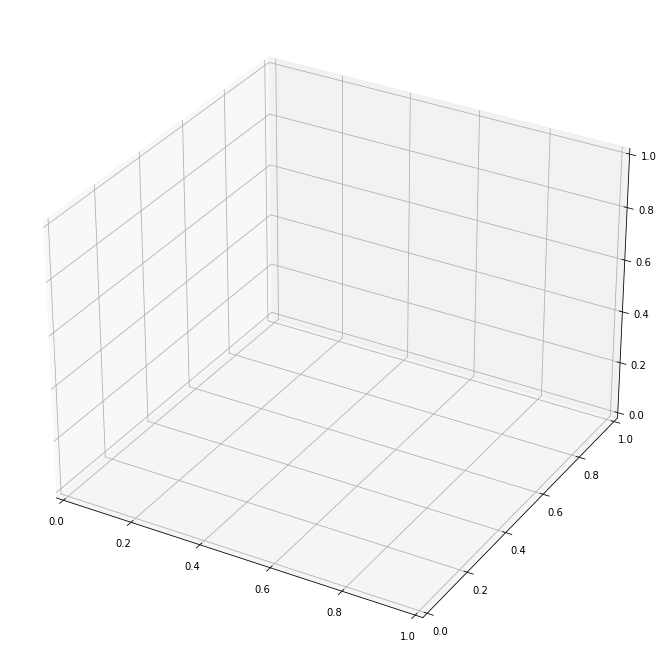

In [3]:
############   各传感器独立观测效果   ###########
path = '/media/ubuntu/zhi_chuan_len-/kitti/kitti_raw_data/2011_09_30/2011_09_30_drive_0027_sync/'
gt_file_path   = "/media/ubuntu/zhi_chuan_len-/kitti/dataset/sequences/07/poses.txt"
FPS = 10

fig = plt.figure()
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

x1 = np.array(gt_data)[:, 0]
y1 = np.array(gt_data)[:, 1]
z1 = np.array(gt_data)[:, 2]



raw_data = get_raw_data(path)
gt_data  = get_gt_data(gt_file_path)

ax.plot(np.array(gt_data)[:, 0], np.array(gt_data)[:, 1], np.array(gt_data)[:, 2], label='ground truth')

# odom_imu = get_odom_from_imu(raw_data)
# ax.plot(np.array(odom_imu)[:, 0], np.array(odom_imu)[:, 1], np.array(odom_imu)[:, 2], label='imu')


odom_gps = get_odom_from_gps(raw_data)
# ax.plot(np.array(odom_gps)[:, 0], np.array(odom_gps)[:, 1], np.array(odom_gps)[:, 2], label='gps')

odom_gps_after_random = get_gps_after_random(raw_data)
ax.plot(np.array(odom_gps_after_random)[:, 0], np.array(odom_gps_after_random)[:, 1], np.array(odom_gps_after_random)[:, 2], label='gps after disturb')


# odom_odom = get_odom_from_gps_odom(odom_gps)
# ax.plot(np.array(odom_odom)[:, 0], np.array(odom_odom)[:, 1], np.array(odom_odom)[:, 2], label='odom')

odom_odom_after_ekf = get_odom_from_gps_odom_after_ekf(odom_gps)
ax.plot(np.array(odom_odom_after_ekf)[:, 0], np.array(odom_odom_after_ekf)[:, 1], np.array(odom_odom_after_ekf)[:, 2], label='odom after ekf')


all_sensor_data = get_odom_all_sensor(gt_data,odom_gps)
ax.plot(np.array(all_sensor_data)[:, 0], np.array(all_sensor_data)[:, 1], np.array(all_sensor_data)[:, 2], label='odom after GPS correct')


# 设置坐标轴比例尺相同
max_range = np.array([x1.max()-x1.min(), y1.max()-y1.min(), z1.max()-z1.min()]).max()
Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(x1.max()+x1.min())
Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(y1.max()+y1.min())
Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(z1.max()+z1.min())
for xb, yb, zb in zip(Xb, Yb, Zb):
    ax.plot([xb], [yb], [zb], 'w')

# ax.set_box_aspect([1,1,1])  # 设置坐标轴比例尺相同
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.legend()

plt.show()

In [2]:
#########################   SCC ########################

def get_gt(poses_file):
    with open(poses_file) as f:
        lines = f.readlines()
        poses = [list(map(float, l.split())) for l in lines]

    # 提取位置和四元数信息
    poses = np.array(poses)
    poses = poses[:, 1:]
    positions = poses[:, :3]
    quaternions = poses[:, 3:]

    # 四元数转换为欧拉角yaw
    ys = np.arctan2(2*(quaternions[:, 3]*quaternions[:, 2] + quaternions[:, 0]*quaternions[:, 1]), 
                    1 - 2*(quaternions[:, 1]**2 + quaternions[:, 2]**2))
    
    first_p = copy.deepcopy(positions[0]) 
    first_y = copy.deepcopy(ys[0])  
    for i in range(len(positions)):
        positions[i] = positions[i] - first_p
        ys[i] = ys[i] - first_y
    
    return positions, ys

def add_continuous_error(positions, ys, error_scale):

    # Add continuous error to each position
    prev_error = np.zeros(3)
    noisy_positions = []
    for i in range(len(positions)):
        error = error_scale * np.random.randn(3) + prev_error
        prev_error = error
        noisy_positions.append(positions[i] + error)

    return np.array(noisy_positions), ys



def cant_loop(positions, ys, error_scale):
    locations  = []
    yaws       = []
    dis_d      = []
    true_yaw_d = []
    fake_yaw_d = []
    for i in range(len(positions)):
        if i == 0:
            dis_d.append(np.linalg.norm([positions[i][0],positions[i][1]]))
            true_yaw_d.append(ys[i])
        else:
            dis_d.append(np.linalg.norm([positions[i][1]-positions[i-1][1],positions[i][0]-positions[i-1][0]]))
            true_yaw_d.append(np.arctan2(positions[i][1]-positions[i-1][1],positions[i][0]-positions[i-1][0]))


    for i in range(len(positions)):
        if i == 0 :
            locations.append([0,0,0])
            yaws.append(0)
        else :
            w = yaws[-1] + true_yaw_d[i]
            x = locations[-1][0] + dis_d[i] * np.cos(true_yaw_d[i]*error_scale)
            y = locations[-1][1] + dis_d[i] * np.sin(true_yaw_d[i]*error_scale)
            z = positions[i][2]
            locations.append([x,y,z])
            yaws.append(w)

    return np.array(locations) , np.array(yaws)


def plot_slam_gt_my(poses_file,slam_name,error_scale,same_box_aspect):
    positions_gt, ys_gt = get_gt(poses_file)
    positions, ys = add_continuous_error(positions_gt,ys_gt,error_scale)
#     positions, ys = cant_loop(positions_gt,ys_gt,100*error_scale+1)

    # 绘制三维轨迹
    fig = plt.figure()
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(positions_gt[:, 0], positions_gt[:, 1], positions_gt[:, 2], label='Ground truth')
    ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], label=slam_name)
    ax.set_xlabel('X(m)')
    ax.set_ylabel('Y(m)')
    ax.set_zlabel('Z(m)')
    plt.title(poses_file.split('/')[-1].split('.')[0]) 

    # 设置坐标轴比例尺相同
    if same_box_aspect:
        x1 = np.array(positions_gt)[:, 0]
        y1 = np.array(positions_gt)[:, 1]
        z1 = np.array(positions_gt)[:, 2]
        max_range = np.array([x1.max()-x1.min(), y1.max()-y1.min(), z1.max()-z1.min()]).max()
        Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(x1.max()+x1.min())
        Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(y1.max()+y1.min())
        Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(z1.max()+z1.min())
        for xb, yb, zb in zip(Xb, Yb, Zb):
            ax.plot([xb], [yb], [zb], 'w')

    
    ax.legend()
    plt.show()


def plot_slam_gt_other(poses_file,slam_name,error_scale,same_box_aspect):
    positions_gt, ys_gt = get_gt(poses_file)
#     positions, ys = add_continuous_error(positions_gt,ys_gt,error_scale)
    positions, ys = cant_loop(positions_gt,ys_gt,error_scale)

    # 绘制三维轨迹
    fig = plt.figure()
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(positions_gt[:, 0], positions_gt[:, 1], positions_gt[:, 2], label='Ground truth')
    ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], label=slam_name)
    ax.set_xlabel('X(m)')
    ax.set_ylabel('Y(m)')
    ax.set_zlabel('Z(m)')
    plt.title(poses_file.split('/')[-1].split('.')[0]) 

    # 设置坐标轴比例尺相同
    if same_box_aspect:
        x1 = np.array(positions_gt)[:, 0]
        y1 = np.array(positions_gt)[:, 1]
        z1 = np.array(positions_gt)[:, 2]
        max_range = np.array([x1.max()-x1.min(), y1.max()-y1.min(), z1.max()-z1.min()]).max()
        Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(x1.max()+x1.min())
        Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(y1.max()+y1.min())
        Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(z1.max()+z1.min())
        for xb, yb, zb in zip(Xb, Yb, Zb):
            ax.plot([xb], [yb], [zb], 'w')

    
    ax.legend()
    plt.show()
    
    
    
def half_plot_slam_gt_my(poses_file,slam_name,error_scale,same_box_aspect,where_split):
    positions_gt, ys_gt = get_gt(poses_file)
    where_split_ = int(where_split*len(positions_gt))
    positions, ys = add_continuous_error(positions_gt[where_split_:],ys_gt[where_split_:],error_scale)
    #     positions, ys = cant_loop(positions_gt,ys_gt,100*error_scale+1)
    positions = np.vstack([positions_gt[:where_split_],positions])
    # 绘制三维轨迹
    fig = plt.figure()
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(positions_gt[:, 0], positions_gt[:, 1], positions_gt[:, 2], label='Ground truth')
    ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], label=slam_name)
    ax.set_xlabel('X(m)')
    ax.set_ylabel('Y(m)')
    ax.set_zlabel('Z(m)')
    plt.title(poses_file.split('/')[-1].split('.')[0]) 

    # 设置坐标轴比例尺相同
    if same_box_aspect:
        x1 = np.array(positions_gt)[:, 0]
        y1 = np.array(positions_gt)[:, 1]
        z1 = np.array(positions_gt)[:, 2]
        max_range = np.array([x1.max()-x1.min(), y1.max()-y1.min(), z1.max()-z1.min()]).max()
        Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(x1.max()+x1.min())
        Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(y1.max()+y1.min())
        Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(z1.max()+z1.min())
        for xb, yb, zb in zip(Xb, Yb, Zb):
            ax.plot([xb], [yb], [zb], 'w')


    ax.legend()
    plt.show()

def half_plot_slam_gt_other(poses_file,slam_name,error_scale,same_box_aspect,where_split):
    positions_gt, ys_gt = get_gt(poses_file)
    where_split_ = int(where_split*len(positions_gt))
#     positions, ys = add_continuous_error(positions_gt,ys_gt,error_scale)
    positions, ys = cant_loop(positions_gt,ys_gt,error_scale)

    positions = np.vstack([positions_gt[1:where_split_],positions])
    # 绘制三维轨迹
    fig = plt.figure()
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(positions_gt[:, 0], positions_gt[:, 1], positions_gt[:, 2], label='Ground truth')
    ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], label=slam_name)
    ax.set_xlabel('X(m)')
    ax.set_ylabel('Y(m)')
    ax.set_zlabel('Z(m)')
    plt.title(poses_file.split('/')[-1].split('.')[0]) 

    # 设置坐标轴比例尺相同
    if same_box_aspect:
        x1 = np.array(positions_gt)[:, 0]
        y1 = np.array(positions_gt)[:, 1]
        z1 = np.array(positions_gt)[:, 2]
        max_range = np.array([x1.max()-x1.min(), y1.max()-y1.min(), z1.max()-z1.min()]).max()
        Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(x1.max()+x1.min())
        Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(y1.max()+y1.min())
        Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(z1.max()+z1.min())
        for xb, yb, zb in zip(Xb, Yb, Zb):
            ax.plot([xb], [yb], [zb], 'w')


    ax.legend()
    plt.show()


def plot_RPE_my(poses_file,slam_name,error_scale,same_box_aspect):
    
    positions_gt, ys_gt = get_gt(poses_file)
    positions, ys = add_continuous_error(positions_gt,ys_gt,error_scale)

    
    gt_xyz = positions_gt
    gt_yaw = ys_gt

    noisy_xyz = positions
    noisy_yaw = ys

    # 计算误差
    print(noisy_xyz.shape)
    print(gt_xyz.shape)
    error_xyz = np.sqrt(np.sum((noisy_xyz - gt_xyz)**2, axis=1))
    error_yaw = np.abs(noisy_yaw - gt_yaw)

    # 绘制图像
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')


    # # 绘制ground truth轨迹
    # ax.plot(gt_xyz[:, 0], gt_xyz[:, 1], gt_xyz[:, 2], color='blue', label='Ground Truth')

    # 绘制带误差的轨迹，颜色根据误差值设定
    cmap = plt.get_cmap('jet')
    normalize = plt.Normalize(vmin=0, vmax=max(error_xyz))
    color = cmap(normalize(error_xyz))
    ax.scatter(noisy_xyz[:, 0], noisy_xyz[:, 1], noisy_xyz[:, 2], c=color, label=slam_name)

    # 添加颜色条
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
    sm.set_array([])
    fig.colorbar(sm)
    
    # 设置坐标轴比例尺相同
    if same_box_aspect:
        
        x1 = np.array(positions_gt)[:, 0]
        y1 = np.array(positions_gt)[:, 1]
        z1 = np.array(positions_gt)[:, 2]
        max_range = np.array([x1.max()-x1.min(), y1.max()-y1.min(), z1.max()-z1.min()]).max()
        Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(x1.max()+x1.min())
        Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(y1.max()+y1.min())
        Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(z1.max()+z1.min())
        for xb, yb, zb in zip(Xb, Yb, Zb):
            ax.plot([xb], [yb], [zb], 'w')
    
    ax.set_xlabel('X(m)')
    ax.set_ylabel('Y(m)')
    ax.set_zlabel('Z(m)')
    plt.title(poses_file.split('/')[-1].split('.')[0]) 
    
    # 设置图例
    ax.legend()

    plt.show()   

def plot_RPE_other(poses_file,slam_name,error_scale,same_box_aspect):
    
    positions_gt, ys_gt = get_gt(poses_file)
    positions, ys = cant_loop(positions_gt,ys_gt,error_scale)
    
    gt_xyz = positions_gt
    gt_yaw = ys_gt

    noisy_xyz = positions
    noisy_yaw = ys

    # 计算误差
    print(noisy_xyz.shape)
    print(gt_xyz.shape)
    error_xyz = np.sqrt(np.sum((noisy_xyz - gt_xyz)**2, axis=1))
    error_yaw = np.abs(noisy_yaw - gt_yaw)

    # 绘制图像
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')


    # # 绘制ground truth轨迹
    # ax.plot(gt_xyz[:, 0], gt_xyz[:, 1], gt_xyz[:, 2], color='blue', label='Ground Truth')

    # 绘制带误差的轨迹，颜色根据误差值设定
    cmap = plt.get_cmap('jet')
    normalize = plt.Normalize(vmin=0, vmax=max(error_xyz))
    color = cmap(normalize(error_xyz))
    ax.scatter(noisy_xyz[:, 0], noisy_xyz[:, 1], noisy_xyz[:, 2], c=color, label=slam_name)

    # 添加颜色条
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
    sm.set_array([])
    fig.colorbar(sm)
    
    # 设置坐标轴比例尺相同
    if same_box_aspect:
        
        x1 = np.array(positions_gt)[:, 0]
        y1 = np.array(positions_gt)[:, 1]
        z1 = np.array(positions_gt)[:, 2]
        max_range = np.array([x1.max()-x1.min(), y1.max()-y1.min(), z1.max()-z1.min()]).max()
        Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(x1.max()+x1.min())
        Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(y1.max()+y1.min())
        Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(z1.max()+z1.min())
        for xb, yb, zb in zip(Xb, Yb, Zb):
            ax.plot([xb], [yb], [zb], 'w')
    
    ax.set_xlabel('X(m)')
    ax.set_ylabel('Y(m)')
    ax.set_zlabel('Z(m)')
    plt.title(poses_file.split('/')[-1].split('.')[0]) 
    
    # 设置图例
    ax.legend()

    plt.show()


<Figure size 432x288 with 0 Axes>

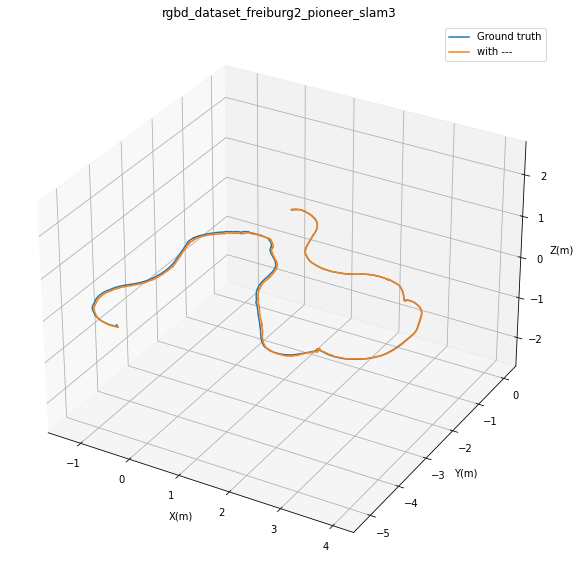

<Figure size 432x288 with 0 Axes>

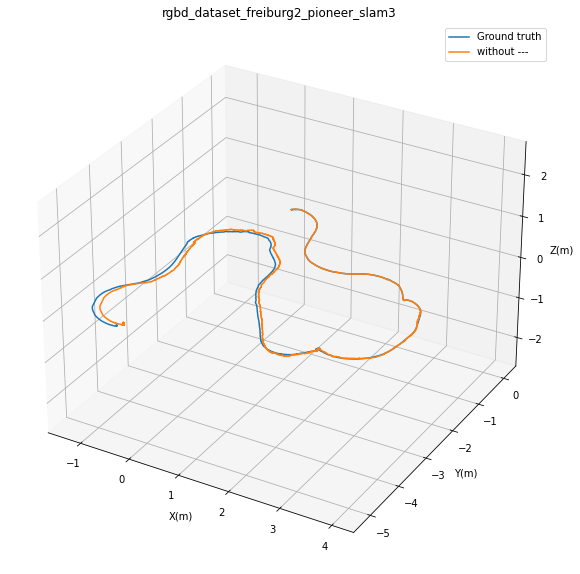

In [4]:
# poses_file = '/home/ubuntu/TestData/SCC/TUM_ground_truth/handeld/rgbd_dataset_freiburg1_room.txt'   
# poses_file = '/home/ubuntu/TestData/SCC/TUM_ground_truth/handeld/rgbd_dataset_freiburg2_360_kidnap.txt'
# poses_file = '/home/ubuntu/TestData/SCC/TUM_ground_truth/handeld/rgbd_dataset_freiburg2_360_hemisphere.txt'

# poses_file = '/home/ubuntu/TestData/SCC/TUM_ground_truth/robot/rgbd_dataset_freiburg2_pioneer_slam.txt' 
# poses_file = '/home/ubuntu/TestData/SCC/TUM_ground_truth/robot/rgbd_dataset_freiburg2_pioneer_slam2.txt' 
poses_file = '/home/ubuntu/TestData/SCC/TUM_ground_truth/robot/rgbd_dataset_freiburg2_pioneer_slam3.txt' 

same_box_aspect = True    #三坐标轴比例尺是否统一
# plot_slam_gt_my(poses_file,"my_slam",0.0003,same_box_aspect)
# plot_slam_gt_other(poses_file,"other_slam",0.995,same_box_aspect)
half_plot_slam_gt_my(poses_file,"with ---",0.0003,same_box_aspect,0.4)
half_plot_slam_gt_my(poses_file,"without ---",0.0006,same_box_aspect,0.4)
# half_plot_slam_gt_other(poses_file,"other_slam",0.995,same_box_aspect,0.1)

# plot_RPE_my(poses_file,"my_slam",0.0003,same_box_aspect)
# plot_RPE_other(poses_file,"other_slam",0.995,same_box_aspect)

array([[ 0.000e+00,  0.000e+00,  0.000e+00],
       [-4.000e-04, -8.000e-04, -3.000e-04],
       [-8.000e-04, -8.000e-04, -2.000e-04],
       ...,
       [-4.497e-01, -8.154e-01, -6.390e-02],
       [-4.498e-01, -8.153e-01, -6.390e-02],
       [-4.497e-01, -8.152e-01, -6.380e-02]])

<Figure size 432x288 with 0 Axes>

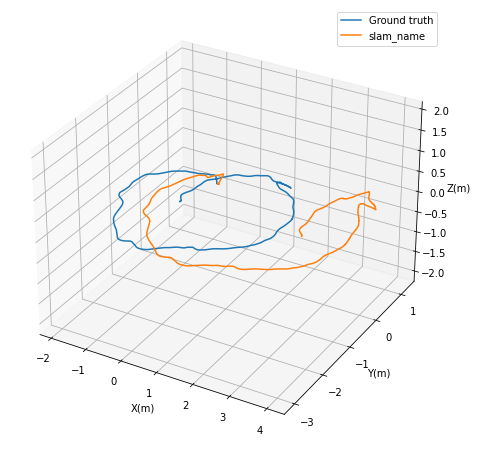

In [325]:
error_scale = 0.0006
positions_gt, ys_gt = get_gt(poses_file)


        
prev_imu_data = None
locations  = []
yaws       = []
dis_d      = []
true_yaw_d = []
fake_yaw_d = []
for i in range(len(positions_gt)):
    if i == 0:
        dis_d.append(np.linalg.norm([positions_gt[i][0],positions_gt[i][1]]))
        true_yaw_d.append(ys_gt[i])
    else:
        dis_d.append(np.linalg.norm([positions_gt[i][1]-positions_gt[i-1][1],positions_gt[i][0]-positions_gt[i-1][0]]))
        true_yaw_d.append(np.arctan2(positions_gt[i][1]-positions_gt[i-1][1],positions_gt[i][0]-positions_gt[i-1][0]))


for i in range(len(positions_gt)):
    if i == 0 :
        locations.append([0,0,0])
        yaws.append(0)
    else :
        w = yaws[-1] + true_yaw_d[i]
        x = locations[-1][0] + dis_d[i] * np.cos(true_yaw_d[i]*0.8)
        y = locations[-1][1] + dis_d[i] * np.sin(true_yaw_d[i]*0.8)
        z = positions_gt[i][2]
        locations.append([x,y,z])
        yaws.append(w)


cant_loop_pos = np.array(locations)



# 绘制三维轨迹
fig = plt.figure()
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(positions_gt[:, 0], positions_gt[:, 1], positions_gt[:, 2], label='Ground truth')
ax.plot(cant_loop_pos[:, 0], cant_loop_pos[:, 1], cant_loop_pos[:, 2], label="slam_name")
ax.set_xlabel('X(m)')
ax.set_ylabel('Y(m)')
ax.set_zlabel('Z(m)')

# 设置坐标轴比例尺相同
if same_box_aspect:
    x1 = np.array(positions_gt)[:, 0]
    y1 = np.array(positions_gt)[:, 1]
    z1 = np.array(positions_gt)[:, 2]
    max_range = np.array([x1.max()-x1.min(), y1.max()-y1.min(), z1.max()-z1.min()]).max()
    Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(x1.max()+x1.min())
    Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(y1.max()+y1.min())
    Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(z1.max()+z1.min())
    for xb, yb, zb in zip(Xb, Yb, Zb):
        ax.plot([xb], [yb], [zb], 'w')


ax.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

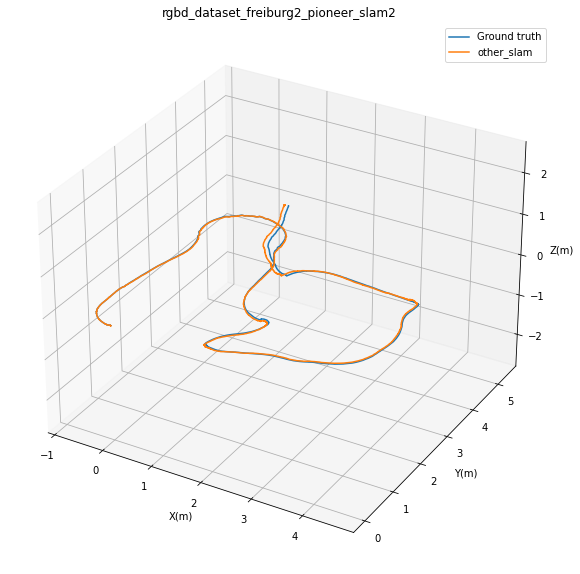

In [44]:
positions

array([[-0.56408818,  1.19310194, -0.01861385],
       [-0.56436602,  1.19433733, -0.0187963 ],
       [-0.56413327,  1.19527216, -0.01934682],
       ...,
       [-0.5645    ,  1.1899    , -0.0189    ],
       [-0.5645    ,  1.191     , -0.0185    ],
       [-0.5648    ,  1.1921    , -0.0186    ]])

In [41]:
positions_gt

array([[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
       [ 2.0000e-04,  0.0000e+00, -2.0000e-04],
       [ 2.0000e-04,  0.0000e+00, -2.0000e-04],
       ...,
       [ 4.3070e-01,  5.3332e+00, -6.4700e-02],
       [ 4.3080e-01,  5.3332e+00, -6.4600e-02],
       [ 4.3070e-01,  5.3332e+00, -6.4700e-02]])